In [1]:
import json 
import pandas as pd
import datetime
from pandas.io.json import json_normalize
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import re
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split 

[nltk_data] Downloading package stopwords to /Users/ankit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ankit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df=pd.read_json('Downloads/uspto.json',lines=True)

In [3]:
objectdata=df.object.dropna().apply(pd.Series)

## Labelling the data as per their status

In [4]:
status=objectdata.status.unique()

In [5]:
approved=[status[5]]
approved

['Patented Case']

In [6]:
disapproval=[status[0],status[2],status[1],status[3],status[7],status[8],status[10],status[11],status[16],status[18],status[4],status[6],status[9],status[12],status[13],status[14],status[15],status[17]]
disapproval

['Publications -- Issue Fee Payment Verified',
 'Awaiting TC Resp., Issue Fee Not Paid',
 'Non Final Action Mailed',
 'Final Rejection Mailed',
 'Abandoned  --  Failure to Respond to an Office Action',
 'Advisory Action Mailed',
 'Response to Non-Final Office Action Entered and Forwarded to Examiner',
 'Patent Expired Due to NonPayment of Maintenance Fees Under 37 CFR 1.362',
 'Provisional Application Expired',
 'Expressly Abandoned  --  During Examination',
 'Docketed New Case - Ready for Examination',
 'Sent to Classification contractor',
 "Examiner's Answer to Appeal Brief Mailed",
 'Appeal Brief (or Supplemental Brief) Entered and Forwarded to Examiner',
 'Application Dispatched from Preexam, Not Yet Docketed',
 'RO PROCESSING COMPLETED-PLACED IN STORAGE',
 'PCT - International Search Report Mailed to IB',
 'Application Undergoing Preexam Processing']

In [7]:
objectdata['result']=[None for i in range(len(objectdata['status']))]

In [8]:
for i in range(len(objectdata['status'])):
    if objectdata['status'][i] in approved:
        objectdata['result'][i]=0
    elif objectdata['status'][i] in disapproval:
        objectdata['result'][i]=1

## Data Cleaning

In [9]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [10]:
def get_top_n_words(corpus, n=None,reverse=True):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=reverse)
    remwords= words_freq[:n]
    return [i[0] for i in remwords]

In [11]:
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    nonnumeric = re.sub(r"\d+","",normalized)
    processed = re.sub(r'\W*\b\w{1,4}\b',"",nonnumeric)
    #y = processed.split()
    return processed

In [12]:
objectdata['summary']=objectdata['summary'].apply(clean)
objectdata['title']=objectdata['title'].apply(clean)

In [13]:
common_words = get_top_n_words(objectdata['summary']+objectdata['title'],30)

In [14]:
common_words

['lidar',
 'system',
 'laser',
 'signal',
 'light',
 'method',
 'point',
 'target',
 'optical',
 'object',
 'source',
 'pulse',
 'image',
 'sensor',
 'using',
 'includes',
 'measurement',
 'first',
 'second',
 'detection',
 'device',
 'surface',
 'système',
 'position',
 'detector',
 'invention',
 'array',
 'information',
 'configured',
 'reflected']

In [15]:
def removewords(doc):
    word_free = " ".join([i for i in doc.split() if i not in common_words])
    return word_free

In [16]:
objectdata['summary']=objectdata['summary'].apply(removewords)
objectdata['title']=objectdata['title'].apply(removewords)

In [17]:
objectdata['filingDate']=objectdata['filingDate'].apply(lambda x: np.NaN if (len(x)<1) else x)
objectdata['filingDate']=objectdata['filingDate'].apply(lambda x: datetime.datetime.strptime(x, "%a %b %d %H:%M:%S %z %Y") if isinstance(x,str) else x) 
objectdata=objectdata.sort_values(by='filingDate')
objectdata=objectdata.reset_index(drop=True)

In [18]:
objectdata.result.nunique()

2

In [19]:
objectdata['title_sum'] = objectdata.title + objectdata.summary
objectdata.drop(['id','title','summary','status','filingDate','publicationNumber','publicationDate','objectType'],axis=1, inplace=True)

In [20]:
vectorizer = TfidfVectorizer(sublinear_tf=True, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = vectorizer.fit_transform(objectdata['title_sum'])
labels = objectdata['result']
features.shape

(358, 12062)

In [21]:
objectdata.head()

,result,title_sum
0,1,removal background backscattering subtraction ...
1,0,control photomultiplier detecting differential...
2,0,imaging
3,1,imaging nonvisible
4,1,


## Choosing a Classifier

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [23]:
models = [
    LogisticRegression(random_state=0, C=0.9),
    RandomForestClassifier(n_estimators=400, max_depth=50, random_state=0),
    XGBClassifier(),
    MultinomialNB(alpha=0.01),
    svm.SVC()
]

In [24]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, list(labels), scoring='precision', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [25]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.594804
MultinomialNB             0.582721
RandomForestClassifier    0.595038
SVC                       0.597778
XGBClassifier             0.598425
Name: accuracy, dtype: float64

## Evaluation of Support Vector Classifier using Accuracy metric

In [26]:
trainX, testX, trainy, testy = train_test_split(features, list(labels), test_size=0.2, random_state=2)

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import r2_score,mean_squared_error,roc_curve,auc
import matplotlib.pyplot as matplot_plt

# Function for evaluation reports
def get_eval(clf, X_train, y_train,y_test,y_pred):
    
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    #Results Computed------
    
    #scores2 = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
    
    #Results Computed------

    #scores3 = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
    
    #Results Computed------

    # The mean score and standard deviation of the score estimate
    print("Resultant Cross Validation Accuracy will be: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    
    #print("Resultant Cross Validation Precision will be: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    
    #Results Computed------
    #print("Resultant Cross Validation roc_auc will be: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    
    
    # Create and print confusion matrix
    print("Confusion Matrix will be\n")
    confusion_res = confusion_matrix(y_test,y_pred)
    
    
    #Results Computed------

    print(confusion_res)
    print("\n")
    print("Classification report\n",classification_report(y_test, y_pred))
    return
  
 # Function to get roc curve
def get_roc (y_test,y_pred):
  
    #True Vs Predicted Value
    print("RMSE")
    print(mean_squared_error(y_test,y_pred))
    
    print("\n R(Square)")
    print(r2_score(y_test,y_pred))
    
    # Compute ROC curve and ROC area for each class
    false_positive_ratio = dict()
    true_positive_ratio = dict()
    #Results Computed------
    roc_auc = dict()
    
    #Results Computed------
    for i in range(2):
        false_positive_ratio[i], true_positive_ratio[i], _ = roc_curve(y_test, y_pred)
        roc_auc[i] = auc(false_positive_ratio[i], true_positive_ratio[i])
    
    
    
    #Plot of a ROC curve
    matplot_plt.figure()
    lw = 2
    matplot_plt.plot(false_positive_ratio[1], true_positive_ratio[1], color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc[1])
    matplot_plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    
    
    #Results Computed------
    
    matplot_plt.xlim([0.0, 1.0])
    matplot_plt.ylim([0.0, 1.0])
    
    
    matplot_plt.xlabel('False Positive Rate')
    matplot_plt.ylabel('True Positive Rate')
    matplot_plt.title('Receiver operating characteristic')
    matplot_plt.legend(loc="lower right")
    matplot_plt.show()
    return

In [31]:
def svm_evaluate(X_train, y_train,X_test, y_test):
    print("Support Vector Classifier")
    svc=svm.SVC().fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = svc.predict(X_test)
    
    # Get Cross Validation and Confusion matrix
    get_eval(svc, X_train, y_train,y_test,y_pred)
    get_roc(y_test,y_pred)
    return

Support Vector Classifier


/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Resultant Cross Validation Accuracy will be: 0.60 (+/- 0.01)
Confusion Matrix will be

[[ 0 30]
 [ 0 42]]


Classification report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.58      1.00      0.74        42

   micro avg       0.58      0.58      0.58        72
   macro avg       0.29      0.50      0.37        72
weighted avg       0.34      0.58      0.43        72

RMSE
0.4166666666666667

 R(Square)
-0.714285714285714


/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


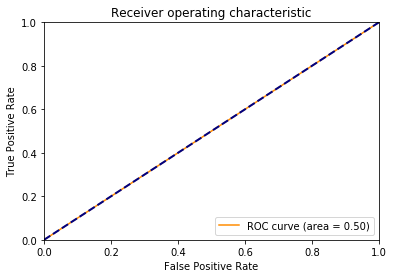

In [32]:
svm_evaluate(trainX,trainy,testX,testy)

In [33]:
model=svm.SVC().fit(features,list(labels))

/Users/ankit/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## Update Model

In [34]:
Updatecounter=0
def update_model():
    objectdata['title']=objectdata['title'].apply(clean)
    objectdata['summary']=objectdata['summary'].apply(clean)
    objectdata['title']=objectdata['title'].apply(removewords)
    objectdata['summary']=objectdata['summary'].apply(removewords)
    objectdata['title_sum'] = objectdata.title + objectdata.summary
    objectdata.drop(['id','title','summary','status','filingDate','publicationNumber','publicationDate','objectType'],axis=1, inplace=True)
    features=vectorizer.transform(objectdata['title_sum'])
    labels=objectdata['result']
    model=svm.SVC().fit(features,list(labels))

## APIS

In [ ]:
from flask import Flask,request
  
app = Flask(__name__) 
  
@app.route('/patentpredict', methods=["POST"]) 
def predict_patent(): 
    req = request.get_json()
    doc=pd.DataFrame(req['object'],index=[0])
    doc['title']=doc['title'].apply(clean)
    doc['summary']=doc['summary'].apply(clean)
    doc['title']=doc['title'].apply(removewords)
    doc['summary']=doc['summary'].apply(removewords)
    doc['title_sum'] = doc.title + doc.summary
    doc.drop(['id','title','summary','status','filingDate','publicationNumber','publicationDate','objectType'],axis=1, inplace=True)
    doc_titsum=vectorizer.transform(doc['title_sum'])
    res=model.predict(doc_titsum)
    if res[0]==0:
        return "Approved"
    elif res[0]==1:
        return "Not approved"

@app.route('/patentrecord',methods=["POST"])
def record_patent():
    req = request.get_json()
    doc=pd.DataFrame(req['object'],index=[0])
    if doc['status'] in approved:
        doc['result']=[0]
    elif doc['status'] in disapproval:
        doc['result']=[1]
    else:
        doc['result']=2
    objectdata.append(doc)
    
    doc['title']=doc['title'].apply(clean)
    doc['summary']=doc['summary'].apply(clean)
    doc['title']=doc['title'].apply(removewords)
    doc['summary']=doc['summary'].apply(removewords)
    doc['title_sum'] = doc.title + doc.summary
    doc.drop(['id','title','summary','status','filingDate','publicationNumber','publicationDate','objectType'],axis=1, inplace=True)
    doc_titsum=vectorizer.transform(doc['title_sum'])
    res=model.predict(doc_titsum)
    if res[0]!=doc['result'][0]:
        Updatecounter+=1
    if Updatecounter>5:
        update_model()
    return "Submitted"
        
    
if __name__ == '__main__': 
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
